# ResNet Classifier

- Dataaset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
- https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/
- https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

## Install

In [14]:
%pip install torch torchvision matplotlib numpy scikit-learn tqdm pandas datasets

Note: you may need to restart the kernel to use updated packages.


## Import

In [15]:
import torch

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


## Load CIFAR10-C

https://huggingface.co/datasets/randall-lab/cifar10-c

- Homepage: https://github.com/hendrycks/robustness
- https://huggingface.co/docs/datasets/en/loading

```
@article{
    hendrycks2019benchmarking, 
    title={Benchmarking neural network robustness to common corruptions and perturbations}, 
    author={Hendrycks, Dan and Dietterich, Thomas}, 
    journal={arXiv preprint arXiv:1903.12261}, 
    year={2019} 
}
```

In [ ]:
from datasets import load_dataset

t_dataset = load_dataset("uoft-cs/cifar10", split="train", trust_remote_code=False)
r_dataset = load_dataset("robro/cifar10-c-parquet", split="train", trust_remote_code=False)

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck",]

t_df_dataset = t_dataset.to_pandas()
r_df_dataset = r_dataset.to_pandas()

display(t_df_dataset)
display(r_df_dataset)

README.md: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/950000 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

,img,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,7
...,...,...
49995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
49996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9
49997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1
49998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1


,image,label,corruption_name,corruption_level
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3,zoom_blur,1
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,8,zoom_blur,1
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,8,zoom_blur,1
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,zoom_blur,1
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,6,zoom_blur,1
...,...,...,...,...
949995,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,8,brightness,5
949996,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3,brightness,5
949997,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,5,brightness,5
949998,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,brightness,5


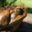

Label: frog


In [29]:
from PIL import Image
import io

example = t_df_dataset.iloc[1]
image = example["img"]
label = example["label"]

stream = io.BytesIO(image['bytes'])
img = Image.open(stream)

display(img)
print(f"Label: {classes[label]}")

In [19]:
# classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck",]
# print(classes)